In [1]:
%matplotlib inline 

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

mpl.rc('font', size=15)

Using TensorFlow backend.


# Import data
Import time series, metadata, and labels. Separate into training and validation data

In [2]:
import pickle

with open('data/training_data.pkl', 'rb') as f:
    data_dict = pickle.load(f)
    
X_conv = data_dict['X'] 
X_meta = data_dict['metaX']
y = data_dict['y']

tfrac = int(0.8*y.shape[0])
X_conv_train = X_conv[:tfrac]
X_conv_val = X_conv[tfrac:]
X_meta_train = X_meta[:tfrac]
X_meta_val = X_meta[tfrac:]
y_train = y[:tfrac]
y_val = y[tfrac:]

print('')
print('X_conv_train shape: {}'.format(X_conv_train.shape))
print('X_conv_val shape  : {}'.format(X_conv_val.shape))
print('X_meta_train shape: {}'.format(X_meta_train.shape))
print('X_meta_val shape  : {}'.format(X_meta_val.shape))
print('y_train shape     : {}'.format(y_train.shape))
print('y_val shape       : {}'.format(y_val.shape))


X_conv_train shape: (6278, 72, 12)
X_conv_val shape  : (1570, 72, 12)
X_meta_train shape: (6278, 8)
X_meta_val shape  : (1570, 8)
y_train shape     : (6278, 14)
y_val shape       : (1570, 14)


# Train neural network for light curves classification
## Create network

In [3]:
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D
from keras.layers import concatenate
from keras.models import Model
from keras import regularizers
from keras.initializers import glorot_normal
from keras.optimizers import Adam

In [4]:
def PhNet(num_classes, conv_shape, dense_shape=None, lr=1e-3, reg=1e-2, dropout=0.1):

    # convolution layer
    conv_input = Input(shape=conv_shape, name='light_curve_input')
    conv = Conv1D(filters=8, 
                  kernel_size=5, 
                  strides=1, 
                  padding='same',
                  kernel_regularizer=regularizers.l2(reg),
                  kernel_initializer=glorot_normal())(conv_input)
    conv = BatchNormalization(axis=2)(conv)
    conv = Activation('relu')(conv)
    conv = MaxPooling1D(2)(conv)
    conv = Conv1D(filters=16, 
                  kernel_size=5, 
                  strides=1, 
                  padding='same',
                  kernel_regularizer=regularizers.l2(reg),
                  kernel_initializer=glorot_normal())(conv_input)
    conv = BatchNormalization(axis=2)(conv)
    conv = Activation('relu')(conv)
    conv = MaxPooling1D(2)(conv)
    conv = Flatten()(conv)
    conv = Dense(32, activation='relu')(conv)
    
    # dense layer
    if dense_shape is not None:
        dense_input = Input(shape=dense_shape, name='meta_data')
        dense = Dense(4, activation='relu')(dense_input)
        dense = BatchNormalization(axis=1)(dense)
        dense = Dense(16, activation='relu')(dense_input)
        dense = BatchNormalization(axis=1)(dense)
        dense = Dense(64, activation='relu')(dense_input)
        dense = BatchNormalization(axis=1)(dense)
        dense = Dense(32, activation='relu')(dense)

        # merge layer
        x = concatenate([conv, dense])
    else: 
        x = conv

    x = Dense(64, activation='relu')(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(num_classes, 
              kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',
              name='output')(x)

    # optimizer
    adam = Adam(lr=lr)
    
    if dense_shape is not None:
        model = Model(inputs=[conv_input, dense_input], outputs=x, name='PhNet')
    else:
        model = Model(inputs=conv_input, outputs=x, name='PhNet')
    model.compile(optimizer=adam , loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [5]:
two_model = PhNet(conv_shape=X_conv_train.shape[1:], 
                  dense_shape=X_meta_train.shape[1:], 
                  num_classes=y.shape[1])

plot_model(two_model, to_file='two_model.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [6]:
two_stats = two_model.fit(x=[X_conv_train, X_meta_train], 
                          y=y_train, 
                          epochs=50, 
                          batch_size=32, 
                          validation_data=([X_conv_val, X_meta_val], y_val),
                          verbose=2)

Train on 6278 samples, validate on 1570 samples
Epoch 1/50
 - 2s - loss: 2.3346 - acc: 0.3128 - val_loss: 2.2900 - val_acc: 0.2739
Epoch 2/50
 - 1s - loss: 2.0318 - acc: 0.3627 - val_loss: 2.2024 - val_acc: 0.3280
Epoch 3/50
 - 1s - loss: 1.8563 - acc: 0.3953 - val_loss: 2.0455 - val_acc: 0.3503
Epoch 4/50
 - 1s - loss: 1.7590 - acc: 0.4250 - val_loss: 1.9933 - val_acc: 0.3395
Epoch 5/50
 - 1s - loss: 1.6395 - acc: 0.4579 - val_loss: 2.0691 - val_acc: 0.3350
Epoch 6/50
 - 1s - loss: 1.5757 - acc: 0.4767 - val_loss: 1.9341 - val_acc: 0.3752
Epoch 7/50
 - 1s - loss: 1.5080 - acc: 0.5030 - val_loss: 1.8303 - val_acc: 0.4223
Epoch 8/50
 - 1s - loss: 1.4523 - acc: 0.5182 - val_loss: 1.9049 - val_acc: 0.3758
Epoch 9/50
 - 1s - loss: 1.4007 - acc: 0.5456 - val_loss: 1.9542 - val_acc: 0.3834
Epoch 10/50
 - 1s - loss: 1.3290 - acc: 0.5599 - val_loss: 1.7284 - val_acc: 0.4389
Epoch 11/50
 - 1s - loss: 1.2831 - acc: 0.5725 - val_loss: 1.7155 - val_acc: 0.4363
Epoch 12/50
 - 1s - loss: 1.2525 - ac

## Plot accuracy curve and confusion matrix

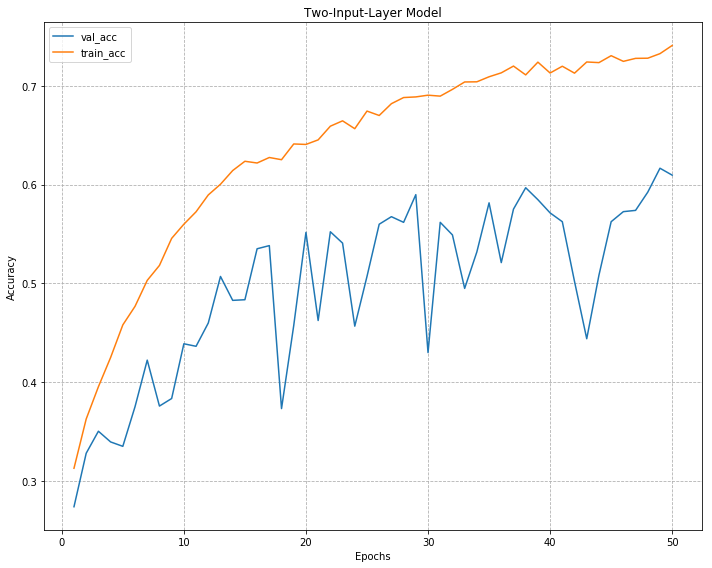

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 8))

val_acc = two_stats.history['val_acc']
train_acc = two_stats.history['acc']
epochs = np.arange(1, len(val_acc)+1)

ax.plot(epochs, val_acc, label='val_acc')
ax.plot(epochs, train_acc, label='train_acc')
ax.set(xlabel='Epochs', ylabel='Accuracy', title='Two-Input-Layer Model')
ax.grid(ls='--')
ax.legend()

fig.tight_layout()

plt.savefig('two_acc.png', dpi=100)

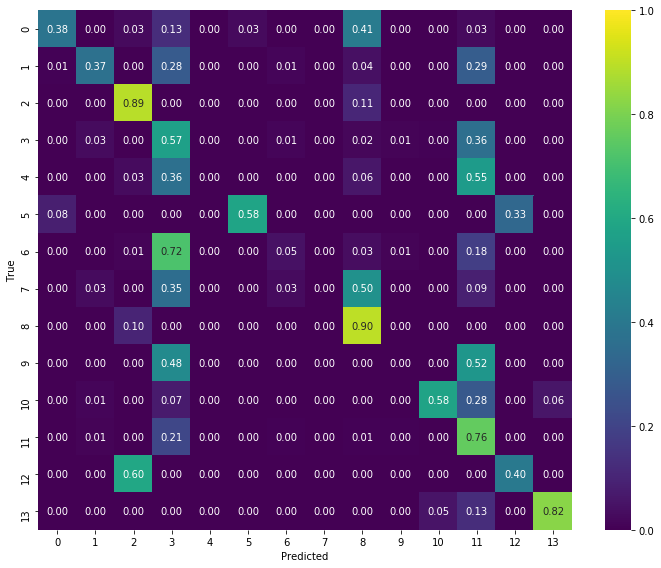

In [8]:
ypred = np.argmax(two_model.predict([X_conv_val, X_meta_val]), axis=1)
ytrue = np.array([np.where(r==1)[0][0] for r in y_val])
cm = metrics.confusion_matrix(ytrue, ypred)
cm = cm/np.sum(cm, axis=1).reshape(-1, 1)

fig, ax = plt.subplots(1, figsize=(10, 8))
sns.heatmap(cm, annot=True, ax=ax, fmt='.2f', cmap='viridis', vmin=0, vmax=1,
           xticklabels=np.arange(14), yticklabels=np.arange(14))
ax.set(ylabel='True', xlabel='Predicted')

fig.tight_layout()

plt.savefig('two_confusion.png', dpi=100)

## Compare performance without metadata

In [9]:
one_model = PhNet(conv_shape=X_conv_train.shape[1:], 
                  num_classes=y.shape[1])

plot_model(one_model, to_file='one_model.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [10]:
one_stats = one_model.fit(x=X_conv_train, 
                          y=y_train,  
                          epochs=50, 
                          batch_size=32, 
                          validation_data=(X_conv_val, y_val),
                          verbose=2)

Train on 6278 samples, validate on 1570 samples
Epoch 1/50
 - 2s - loss: 2.4525 - acc: 0.3036 - val_loss: 2.2801 - val_acc: 0.2662
Epoch 2/50
 - 1s - loss: 2.0423 - acc: 0.3539 - val_loss: 2.1310 - val_acc: 0.3083
Epoch 3/50
 - 1s - loss: 1.8692 - acc: 0.3856 - val_loss: 2.2409 - val_acc: 0.2911
Epoch 4/50
 - 1s - loss: 1.7713 - acc: 0.4130 - val_loss: 2.0205 - val_acc: 0.3280
Epoch 5/50
 - 1s - loss: 1.6823 - acc: 0.4406 - val_loss: 2.0591 - val_acc: 0.3338
Epoch 6/50
 - 1s - loss: 1.6605 - acc: 0.4516 - val_loss: 1.9361 - val_acc: 0.3446
Epoch 7/50
 - 1s - loss: 1.5994 - acc: 0.4747 - val_loss: 1.9727 - val_acc: 0.3573
Epoch 8/50
 - 1s - loss: 1.5593 - acc: 0.4898 - val_loss: 1.9939 - val_acc: 0.3643
Epoch 9/50
 - 1s - loss: 1.5404 - acc: 0.4967 - val_loss: 1.9889 - val_acc: 0.3618
Epoch 10/50
 - 1s - loss: 1.5049 - acc: 0.5096 - val_loss: 1.8546 - val_acc: 0.3962
Epoch 11/50
 - 1s - loss: 1.4462 - acc: 0.5183 - val_loss: 1.9646 - val_acc: 0.3815
Epoch 12/50
 - 1s - loss: 1.4466 - ac

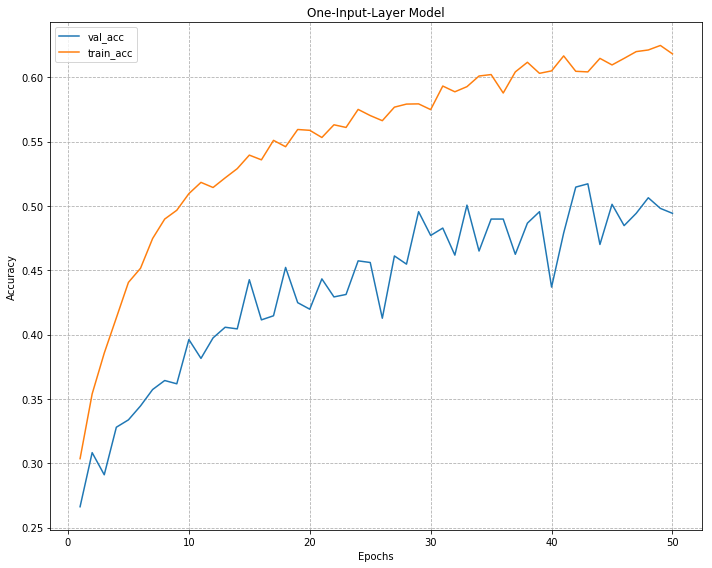

In [11]:
fig, ax = plt.subplots(1, figsize=(10, 8))

val_acc = one_stats.history['val_acc']
train_acc = one_stats.history['acc']
epochs = np.arange(1, len(val_acc)+1)

ax.plot(epochs, val_acc, label='val_acc')
ax.plot(epochs, train_acc, label='train_acc')
ax.set(xlabel='Epochs', ylabel='Accuracy', title='One-Input-Layer Model')
ax.grid(ls='--')
ax.legend()

fig.tight_layout()

# plt.savefig('one_acc.png', dpi=100)

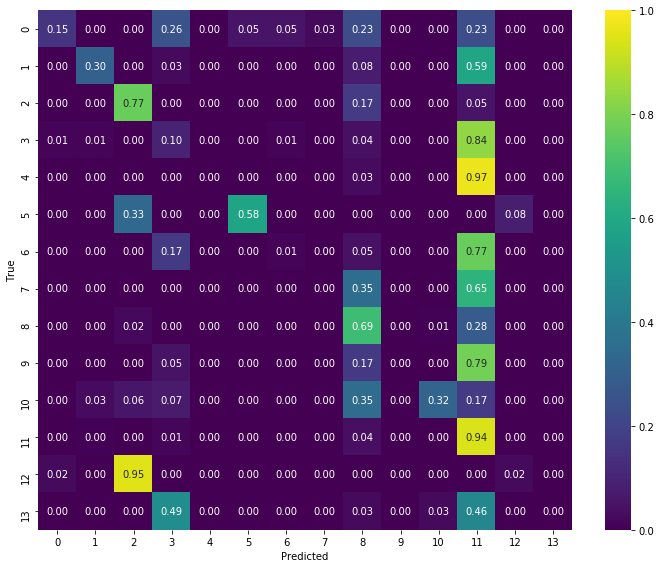

In [12]:
ypred = np.argmax(one_model.predict(X_conv_val), axis=1)
ytrue = np.array([np.where(r==1)[0][0] for r in y_val])
cm = metrics.confusion_matrix(ytrue, ypred)
cm = cm/np.sum(cm, axis=1).reshape(-1, 1)

fig, ax = plt.subplots(1, figsize=(10, 8))
sns.heatmap(cm, annot=True, ax=ax, fmt='.2f', cmap='viridis', vmin=0, vmax=1,
           xticklabels=np.arange(14), yticklabels=np.arange(14))
ax.set(ylabel='True', xlabel='Predicted')

fig.tight_layout()

# plt.savefig('one_confusion.png', dpi=100)

# Ablation Study
## Method I
Remove features from the metadata AFTER training and examine the accuracy. The features of the metadata are RA, DEC, LON, LAT, $Z_{spec}$, $Z_{photo}$, $errZ_{photo}$, $M_{E(B-V)}$

In [13]:
ytrue = np.array([np.where(r==1)[0][0] for r in y_val])
ypred_org = np.argmax(two_model.predict([X_conv_val, X_meta_val]), axis=1)
acc_org = np.sum(ypred_org == ytrue)/ytrue.shape[0]
features = ['RA', 'DEC', 'LON', 'LAT', r'$Z_{spec}$', r'$Z_{photo}$', 'errZ_{photo}', 'M_${E(B-V)}}']

ypred_results = []
acc_results = []

print('')
print('Removed features: Accuracy')
print('--------------------------')
print('%10s: %.4f' % ('original', acc_org))
for i in range(8):

    # set features in metadata to zeros
    X_meta_reduced = X_meta_val.copy() 
    X_meta_reduced[:, i] = 0 
    
    # calculate the accuracy 
    ypred_res = np.argmax(two_model.predict([X_conv_val, X_meta_reduced]), axis=1)
    acc_res = np.sum(ypred_res == ytrue)/ytrue.shape[0]
    
    ypred_results.append(ypred_res)
    acc_results.append(acc_res)
    
    print('%10s: %.4f' % (features[i], acc_res))


Removed features: Accuracy
--------------------------
  original: 0.6096
        ra: 0.4885
       dec: 0.5854
       lon: 0.3847
       lat: 0.6038
     zspec: 0.3166
    zphoto: 0.6051
zphoto_err: 0.6064
     meb-v: 0.6076


Plot the confusion matrix for each prediction

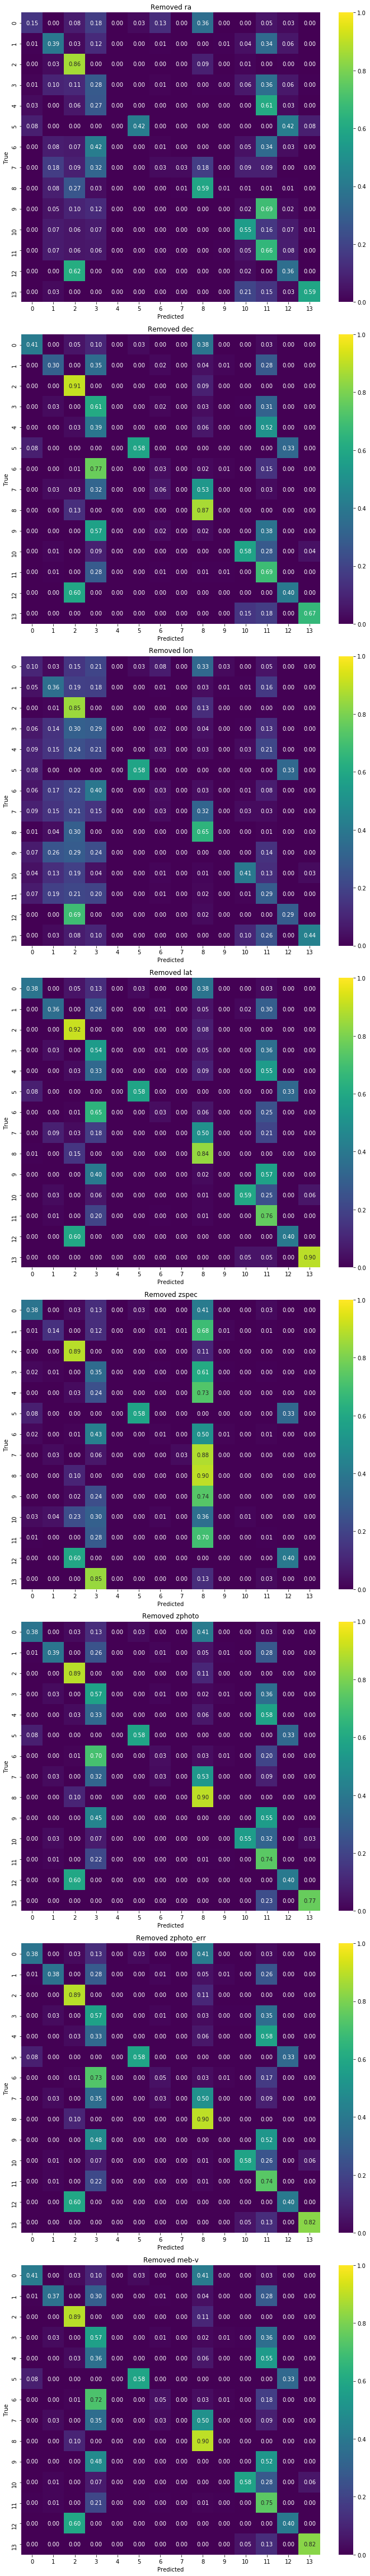

In [14]:
fig, axes = plt.subplots(8, figsize=(10, 8*8))

for i in range(8):
    ax = axes.flatten()[i]
    
    cm = metrics.confusion_matrix(ytrue, ypred_results[i])
    cm = cm/np.sum(cm, axis=1).reshape(-1, 1)
    
    sns.heatmap(cm, annot=True, ax=ax, fmt='.2f', cmap='viridis', vmin=0, vmax=1,
                xticklabels=np.arange(14), yticklabels=np.arange(14))
    ax.set(ylabel='True', xlabel='Predicted', title='Removed %s' % features[i])

fig.tight_layout()

## Method II
Only train on one feature at the time. The features of the metadata are RA, DEC, LON, LAT, $Z_{spec}$, $Z_{photo}$, $errZ_{photo}$, $M_{E(B-V)}$

In [62]:
ypred_results = []
results = []
for i in range(X_meta_val.shape[-1]):
    
    # remove features from metadata 
    X_meta_train_reduced =  X_meta_train[:, i:i+1]
    X_meta_val_reduced =  X_meta_val[:, i:i+1]
    ACF
    # create a model and train
    model = PhNet(conv_shape=X_conv_train.shape[1:], 
                  dense_shape=X_meta_train_reduced.shape[1:], 
                  num_classes=y.shape[1])
    res = model.fit(x=[X_conv_train, X_meta_train_reduced], 
                       y=y_train, 
                       epochs=50, 
                       batch_size=32, 
                       validation_data=([X_conv_val, X_meta_val_reduced], y_val),
                       verbose=0)
    ypred_res = np.argmax(model.predict([X_conv_val, X_meta_val_reduced]), axis=1)
    
    results.append(res)
    ypred_results.append(ypred_res)

Plot training and validation accuracy curve for each of the networks

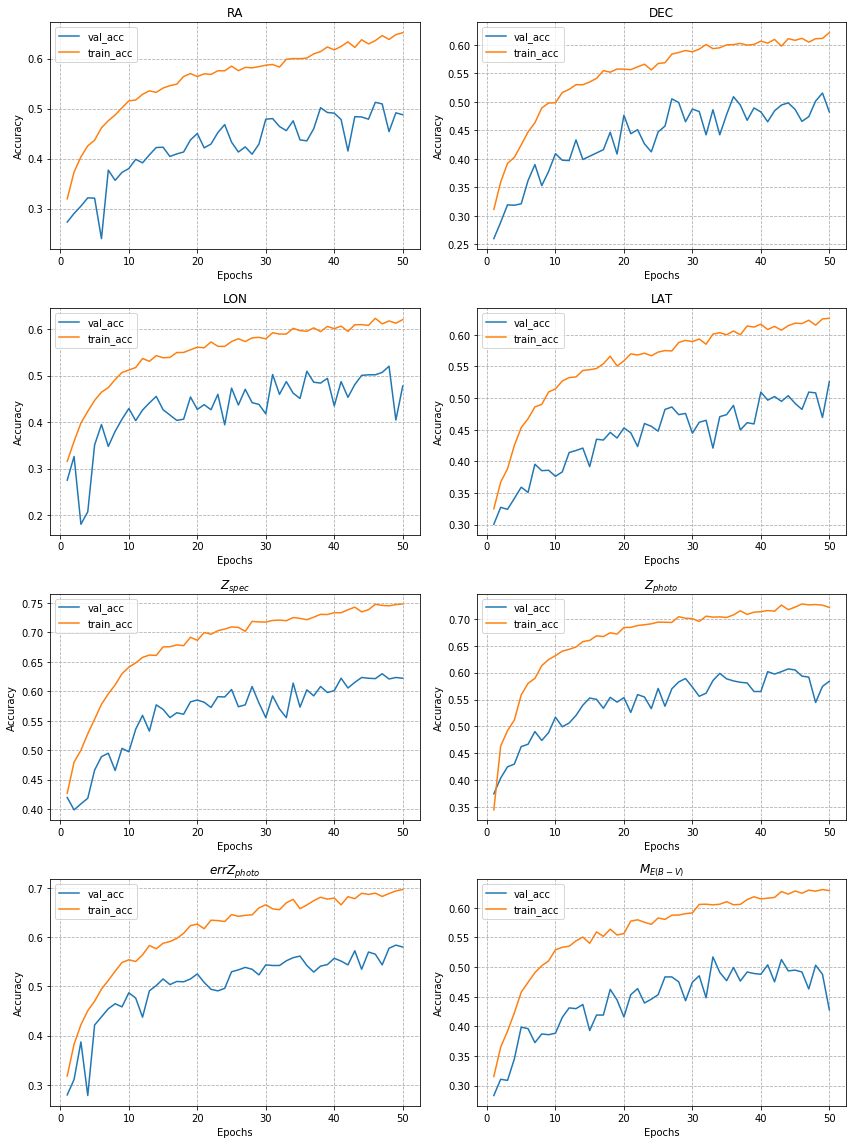

In [68]:
fig, axes = plt.subplots(4, 2, figsize=(12, 2*8))

features = ['RA', 'DEC', 'LON', 'LAT', r'$Z_{spec}$', r'$Z_{photo}$', r'$errZ_{photo}$', r'$M_{E(B-V)}}$']
for i in range(8):
    res = results[i]
    ax = axes.flatten()[i]
    
    val_acc = res.history['val_acc']
    train_acc = res.history['acc']
    epochs = np.arange(1, len(val_acc)+1)

    ax.plot(epochs, val_acc, label='val_acc')
    ax.plot(epochs, train_acc, label='train_acc')
    ax.set(xlabel='Epochs', ylabel='Accuracy', title='%s' % features[i])
    ax.grid(ls='--')
    ax.legend()

fig.tight_layout()

Plot confusion matrix

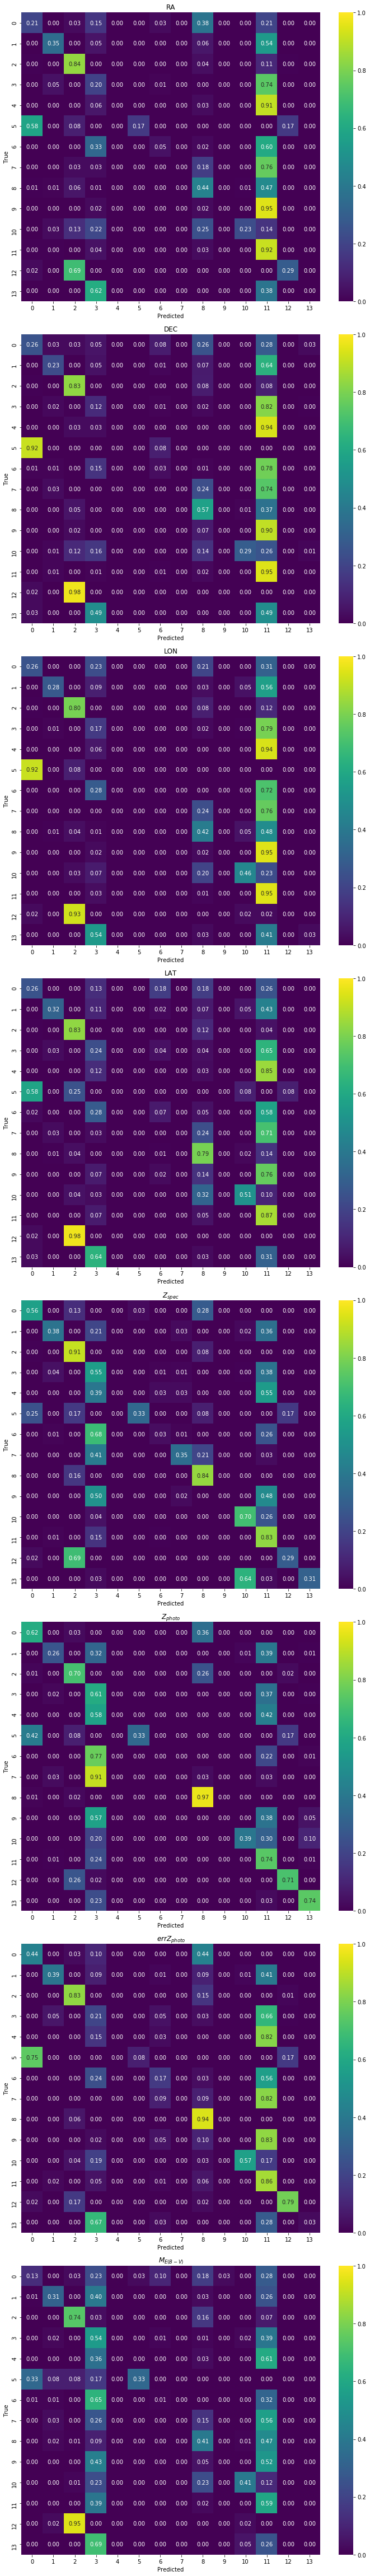

In [69]:
fig, axes = plt.subplots(8, figsize=(10, 8*8))

for i in range(8):
    ax = axes.flatten()[i]
    
    cm = metrics.confusion_matrix(ytrue, ypred_results[i])
    cm = cm/np.sum(cm, axis=1).reshape(-1, 1)
    
    sns.heatmap(cm, annot=True, ax=ax, fmt='.2f', cmap='viridis', vmin=0, vmax=1,
                xticklabels=np.arange(14), yticklabels=np.arange(14))
    ax.set(ylabel='True', xlabel='Predicted', title='%s' % features[i])

fig.tight_layout()

### Training on spectroscopic redshift $Z_{spec}$ versus photometric reshift $Z_{photo}$ and $errZ_{photo}$

In [98]:
X_meta_train_reduced =  X_meta_train[:, 4:5]
X_meta_val_reduced =  X_meta_val[:, 4:5]

# create a model and train
model = PhNet(conv_shape=X_conv_train.shape[1:], 
              dense_shape=X_meta_train_reduced.shape[1:], 
              num_classes=y.shape[1])
res = model.fit(x=[X_conv_train, X_meta_train_reduced], 
                   y=y_train, 
                   epochs=50, 
                   batch_size=32, 
                   validation_data=([X_conv_val, X_meta_val_reduced], y_val),
                   verbose=2)
ypred_res = np.argmax(model.predict([X_conv_val, X_meta_val_reduced]), axis=1)

Train on 6278 samples, validate on 1570 samples
Epoch 1/50
 - 9s - loss: 2.1053 - acc: 0.3523 - val_loss: 1.6804 - val_acc: 0.4025
Epoch 2/50
 - 2s - loss: 1.5548 - acc: 0.4860 - val_loss: 1.5833 - val_acc: 0.4427
Epoch 3/50
 - 2s - loss: 1.4231 - acc: 0.5061 - val_loss: 1.5529 - val_acc: 0.4522
Epoch 4/50
 - 2s - loss: 1.3518 - acc: 0.5190 - val_loss: 1.4887 - val_acc: 0.4688
Epoch 5/50
 - 2s - loss: 1.2840 - acc: 0.5537 - val_loss: 1.5034 - val_acc: 0.4796
Epoch 6/50
 - 2s - loss: 1.2156 - acc: 0.5867 - val_loss: 1.4804 - val_acc: 0.4796
Epoch 7/50
 - 2s - loss: 1.1716 - acc: 0.6118 - val_loss: 1.4312 - val_acc: 0.5064
Epoch 8/50
 - 2s - loss: 1.1496 - acc: 0.6152 - val_loss: 1.3540 - val_acc: 0.5223
Epoch 9/50
 - 3s - loss: 1.0866 - acc: 0.6442 - val_loss: 1.4294 - val_acc: 0.5146
Epoch 10/50
 - 2s - loss: 1.0899 - acc: 0.6371 - val_loss: 1.3986 - val_acc: 0.5255
Epoch 11/50
 - 2s - loss: 1.0674 - acc: 0.6499 - val_loss: 1.4631 - val_acc: 0.5102
Epoch 12/50
 - 2s - loss: 1.0212 - ac

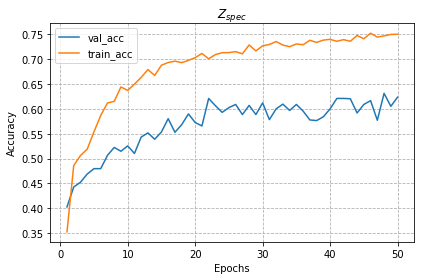

In [99]:
fig, ax = plt.subplots(1)

val_acc = res.history['val_acc']
train_acc = res.history['acc']
epochs = np.arange(1, len(val_acc)+1)

ax.plot(epochs, val_acc, label='val_acc')
ax.plot(epochs, train_acc, label='train_acc')
ax.set(xlabel='Epochs', ylabel='Accuracy', title=r'$Z_{spec}$')
ax.grid(ls='--')
ax.legend()

fig.tight_layout()

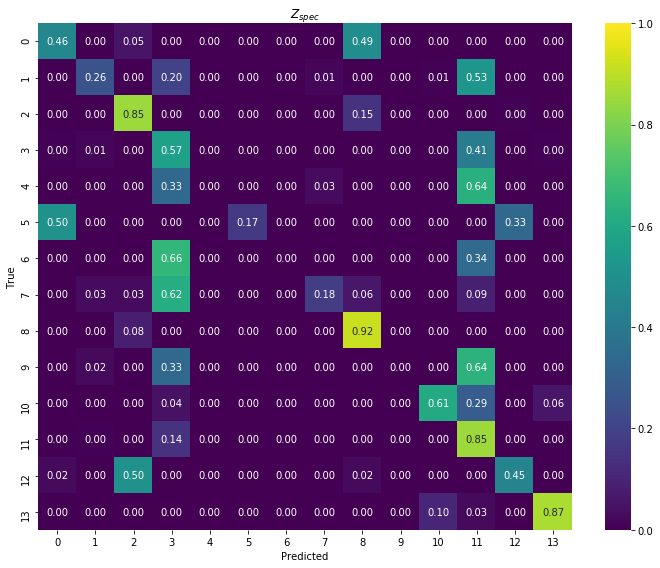

In [100]:
fig, ax = plt.subplots(1, figsize=(10, 8))

cm = metrics.confusion_matrix(ytrue, ypred_res)
cm = cm/np.sum(cm, axis=1).reshape(-1, 1)

sns.heatmap(cm, annot=True, ax=ax, fmt='.2f', cmap='viridis', vmin=0, vmax=1,
            xticklabels=np.arange(14), yticklabels=np.arange(14))
ax.set(ylabel='True', xlabel='Predicted', title=r'$Z_{spec}$')

fig.tight_layout()

In [101]:
X_meta_train_reduced =  X_meta_train[:, 5:7]
X_meta_val_reduced =  X_meta_val[:, 5:7]

# create a model and train
model = PhNet(conv_shape=X_conv_train.shape[1:], 
              dense_shape=X_meta_train_reduced.shape[1:], 
              num_classes=y.shape[1])
res = model.fit(x=[X_conv_train, X_meta_train_reduced], 
                   y=y_train, 
                   epochs=50, 
                   batch_size=32, 
                   validation_data=([X_conv_val, X_meta_val_reduced], y_val),
                   verbose=2)
ypred_res = np.argmax(model.predict([X_conv_val, X_meta_val_reduced]), axis=1)

Train on 6278 samples, validate on 1570 samples
Epoch 1/50
 - 9s - loss: 2.0408 - acc: 0.3633 - val_loss: 1.8540 - val_acc: 0.3796
Epoch 2/50
 - 2s - loss: 1.5450 - acc: 0.4705 - val_loss: 1.6363 - val_acc: 0.4019
Epoch 3/50
 - 2s - loss: 1.4431 - acc: 0.4989 - val_loss: 1.5380 - val_acc: 0.4172
Epoch 4/50
 - 3s - loss: 1.3807 - acc: 0.5191 - val_loss: 1.5133 - val_acc: 0.4255
Epoch 5/50
 - 2s - loss: 1.2982 - acc: 0.5632 - val_loss: 1.5092 - val_acc: 0.4503
Epoch 6/50
 - 2s - loss: 1.2303 - acc: 0.5910 - val_loss: 1.4997 - val_acc: 0.4803
Epoch 7/50
 - 3s - loss: 1.1918 - acc: 0.5988 - val_loss: 1.4989 - val_acc: 0.4783
Epoch 8/50
 - 2s - loss: 1.1625 - acc: 0.6201 - val_loss: 1.5117 - val_acc: 0.4624
Epoch 9/50
 - 3s - loss: 1.1448 - acc: 0.6187 - val_loss: 1.4005 - val_acc: 0.5019
Epoch 10/50
 - 2s - loss: 1.0988 - acc: 0.6338 - val_loss: 1.3910 - val_acc: 0.5261
Epoch 11/50
 - 2s - loss: 1.0831 - acc: 0.6459 - val_loss: 1.3946 - val_acc: 0.5025
Epoch 12/50
 - 2s - loss: 1.0645 - ac

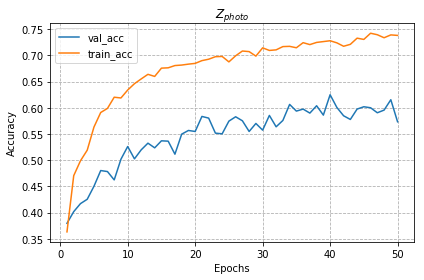

In [102]:
fig, ax = plt.subplots(1)

val_acc = res.history['val_acc']
train_acc = res.history['acc']
epochs = np.arange(1, len(val_acc)+1)

ax.plot(epochs, val_acc, label='val_acc')
ax.plot(epochs, train_acc, label='train_acc')
ax.set(xlabel='Epochs', ylabel='Accuracy', title=r'$Z_{photo}$')
ax.grid(ls='--')
ax.legend()

fig.tight_layout()

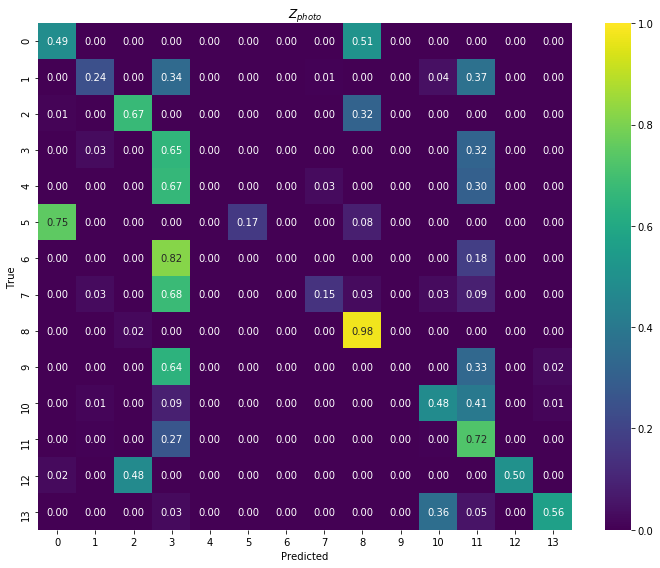

In [103]:
fig, ax = plt.subplots(1, figsize=(10, 8))

cm = metrics.confusion_matrix(ytrue, ypred_res)
cm = cm/np.sum(cm, axis=1).reshape(-1, 1)

sns.heatmap(cm, annot=True, ax=ax, fmt='.2f', cmap='viridis', vmin=0, vmax=1,
            xticklabels=np.arange(14), yticklabels=np.arange(14))
ax.set(ylabel='True', xlabel='Predicted', title=r'$Z_{photo}$')

fig.tight_layout()

### Training on RA, DEC, LAT and LON

In [110]:
X_meta_train_reduced =  X_meta_train[:, :4]
X_meta_val_reduced =  X_meta_val[:, :4]

# create a model and train
model = PhNet(conv_shape=X_conv_train.shape[1:], 
              dense_shape=X_meta_train_reduced.shape[1:], 
              num_classes=y.shape[1])
res = model.fit(x=[X_conv_train, X_meta_train_reduced], 
                   y=y_train, 
                   epochs=50, 
                   batch_size=32, 
                   validation_data=([X_conv_val, X_meta_val_reduced], y_val),
                   verbose=2)
ypred_res = np.argmax(model.predict([X_conv_val, X_meta_val_reduced]), axis=1)

Train on 6278 samples, validate on 1570 samples
Epoch 1/50
 - 10s - loss: 2.3373 - acc: 0.3128 - val_loss: 2.3309 - val_acc: 0.2720
Epoch 2/50
 - 3s - loss: 2.0233 - acc: 0.3590 - val_loss: 2.1494 - val_acc: 0.3293
Epoch 3/50
 - 3s - loss: 1.8479 - acc: 0.3926 - val_loss: 2.1203 - val_acc: 0.3172
Epoch 4/50
 - 3s - loss: 1.7418 - acc: 0.4181 - val_loss: 2.0315 - val_acc: 0.3439
Epoch 5/50
 - 3s - loss: 1.6987 - acc: 0.4392 - val_loss: 2.0405 - val_acc: 0.3395
Epoch 6/50
 - 2s - loss: 1.6295 - acc: 0.4678 - val_loss: 1.9623 - val_acc: 0.3624
Epoch 7/50
 - 3s - loss: 1.5904 - acc: 0.4826 - val_loss: 2.0348 - val_acc: 0.3446
Epoch 8/50
 - 2s - loss: 1.5257 - acc: 0.4924 - val_loss: 1.9511 - val_acc: 0.3624
Epoch 9/50
 - 2s - loss: 1.5321 - acc: 0.4896 - val_loss: 1.8700 - val_acc: 0.3790
Epoch 10/50
 - 2s - loss: 1.4635 - acc: 0.5127 - val_loss: 1.9060 - val_acc: 0.3834
Epoch 11/50
 - 3s - loss: 1.4460 - acc: 0.5159 - val_loss: 1.8961 - val_acc: 0.3662
Epoch 12/50
 - 3s - loss: 1.4102 - a

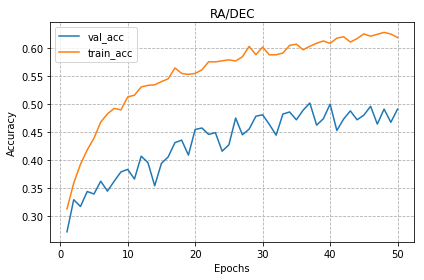

In [111]:
fig, ax = plt.subplots(1)

val_acc = res.history['val_acc']
train_acc = res.history['acc']
epochs = np.arange(1, len(val_acc)+1)

ax.plot(epochs, val_acc, label='val_acc')
ax.plot(epochs, train_acc, label='train_acc')
ax.set(xlabel='Epochs', ylabel='Accuracy', title=r'RA/DEC')
ax.grid(ls='--')
ax.legend()

fig.tight_layout()

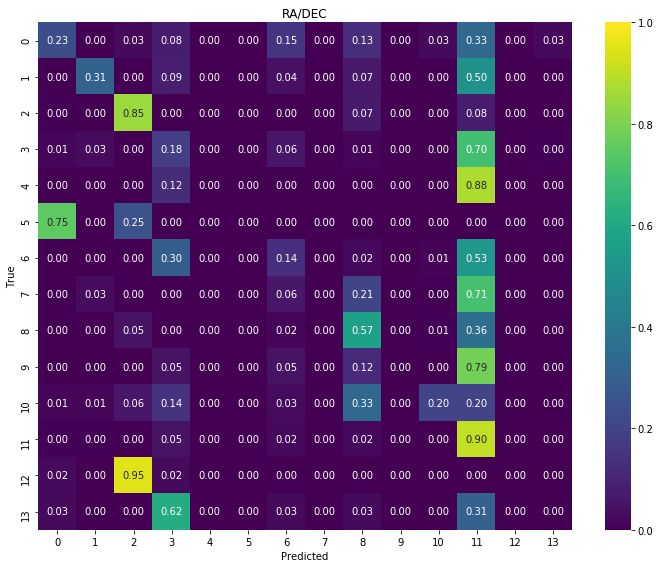

In [112]:
fig, ax = plt.subplots(1, figsize=(10, 8))

cm = metrics.confusion_matrix(ytrue, ypred_res)
cm = cm/np.sum(cm, axis=1).reshape(-1, 1)

sns.heatmap(cm, annot=True, ax=ax, fmt='.2f', cmap='viridis', vmin=0, vmax=1,
            xticklabels=np.arange(14), yticklabels=np.arange(14))
ax.set(ylabel='True', xlabel='Predicted', title=r'RA/DEC')

fig.tight_layout()